In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
from scipy.stats import median_abs_deviation
import numpy as np
import matplotlib.pyplot as plt

# 1. Make raw adata object
## 1.1 Copy data from Google Bucket to here
```bash
    gsutil cp gs://.... ./
```
## 1.2 Install: R dependecies, R, qs library
Needed to convert .qs file into h5ad
- Install R dependencies
```bash
sudo apt-get install -y \
    build-essential \
    libhdf5-dev \
    libzstd-dev \
    liblz4-dev \
    libxxhash-dev \
    libcurl4-openssl-dev \
    libssl-dev \
    libxml2-dev \
    zlib1g-dev
```

- Install R
```bash
sudo apt-get install r-base r-base-dev
 ```

- install qs library
 ```R
install.packages("qs")
 ```

# 2. Extract metadata (x,y) from slidetags .qs file

Be in ```/.../slidetags/``` folder.
Run in bash:
```bash

R --vanilla << 'EOF'
library(qs)

# Read the Seurat object
seurat <- qread("./seurat.qs")

# Extract and save just the metadata
metadata <- seurat@meta.data
write.csv(metadata, "./seurat_metadata.csv", row.names = TRUE)

EOF
```

# 3. Create adata obj

- metadata --> from slidetags
- count matrix --> from cell bender

- use cells present in both

In [8]:
# 1. Load CellBender cleaned counts
adata_cb = sc.read_10x_h5("/home/gdallagl/myworkdir/XDP/data/XDP/disease/240805_SL-EXD_0328_B22FKKYLT4/SI-TT-H1/cellbender/SI-TT-H1_out_filtered.h5")
print(adata_cb)

# 2. Load Slidetag metadata
metadata_slidetags = pd.read_csv("/home/gdallagl/myworkdir/XDP/data/XDP/disease/240805_SL-EXD_0328_B22FKKYLT4/SI-TT-H1/slide_tags/seurat_metadata.csv").rename(columns={"Unnamed: 0": "barcode"})
display(metadata_slidetags)

# cells 
cellbender_cells = set(adata_cb.obs_names)
slidetags_cells = set(metadata_slidetags["barcode"])
intersection_cells = cellbender_cells.intersection(slidetags_cells)

print("cellbender_cells:", len(cellbender_cells))
print("slidetags_cells:", len(slidetags_cells))
print("intersection_cells:", len(intersection_cells))


/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 34907 × 38606
    var: 'gene_ids', 'feature_types', 'genome'


/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,barcode,orig.ident,nCount_RNA,nFeature_RNA,is_cell,pct_intronic,pct_mt,RNA_snn_res.0.8,seurat_clusters,x,y,dbscan_clusters,dbscan_score
0,AAACCAAAGATAACAG-1,Slide-tags,7703,3727,True,0.585746,0.004284,3,3,33013.428400,444.562211,3,0.230731
1,AAACCAAAGCATGGAG-1,Slide-tags,4864,2453,True,0.596834,0.002056,4,4,21225.159553,4193.340108,1,0.942997
2,AAACCAAAGGCGGAGT-1,Slide-tags,6819,2594,True,0.716821,0.000440,11,11,16429.015488,3852.143369,1,0.936590
3,AAACCAAAGGTCTATG-1,Slide-tags,2507,1372,True,0.609493,0.001994,3,3,43242.438818,-1822.457007,0,0.366933
4,AAACCAAAGGTTGTAT-1,Slide-tags,4757,2020,True,0.588186,0.002312,0,0,14118.369028,-4852.270550,1,0.859807
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35981,GTTGTGGGTCGAAGCC-1,Slide-tags,6677,2626,True,0.630523,0.002396,0,0,46045.094685,3106.066837,1,0.827285
35982,GTTGTGGGTGCACGTA-1,Slide-tags,7015,2900,True,0.541554,0.002423,1,1,9851.267283,7168.714885,1,0.705318
35983,GTTGTGGGTGGCGTGT-1,Slide-tags,1892,1272,True,0.630550,0.003700,3,3,17765.143818,-4292.867209,1,0.648054
35984,GTTGTGGGTGGGGTTC-1,Slide-tags,579,428,True,0.552677,0.005181,0,0,8121.352701,3042.716871,1,0.903254


cellbender_cells: 34907
slidetags_cells: 35986
intersection_cells: 34704


In [9]:
# make adata obj

# Subset CellBender AnnData to intersection
adata = adata_cb[sorted(intersection_cells)].copy()

# Subset slidetag metadata to the same cells
metadata_intersection = metadata_slidetags.set_index("barcode").loc[adata.obs_names]

# Add slidetag metadata into AnnData obs
adata.obs = adata.obs.join(metadata_intersection)

# Change var names as MapMyCell wokrs wiht emsableID
adata.var['gene_symbol'] = adata.var.index # Save current index (gene symbols) to a new column
adata.var.set_index('gene_ids', inplace=True) # Set the 'gene_ids' column as the new index
adata.var.index.name = 'ensembl_id' #rename the index

print(adata)
display(adata.obs)
display(adata.var)

AnnData object with n_obs × n_vars = 34704 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'is_cell', 'pct_intronic', 'pct_mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'x', 'y', 'dbscan_clusters', 'dbscan_score'
    var: 'feature_types', 'genome', 'gene_symbol'


/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,orig.ident,nCount_RNA,nFeature_RNA,is_cell,pct_intronic,pct_mt,RNA_snn_res.0.8,seurat_clusters,x,y,dbscan_clusters,dbscan_score
AAACCAAAGATAACAG-1,Slide-tags,7703,3727,True,0.585746,0.004284,3,3,33013.428400,444.562211,3,0.230731
AAACCAAAGCATGGAG-1,Slide-tags,4864,2453,True,0.596834,0.002056,4,4,21225.159553,4193.340108,1,0.942997
AAACCAAAGGCGGAGT-1,Slide-tags,6819,2594,True,0.716821,0.000440,11,11,16429.015488,3852.143369,1,0.936590
AAACCAAAGGTCTATG-1,Slide-tags,2507,1372,True,0.609493,0.001994,3,3,43242.438818,-1822.457007,0,0.366933
AAACCAAAGGTTGTAT-1,Slide-tags,4757,2020,True,0.588186,0.002312,0,0,14118.369028,-4852.270550,1,0.859807
...,...,...,...,...,...,...,...,...,...,...,...,...
GTTGTGGGTCCGTCCA-1,Slide-tags,14946,5144,True,0.597685,0.002074,8,8,57226.380126,-635.403689,11,0.274696
GTTGTGGGTCGAAGCC-1,Slide-tags,6677,2626,True,0.630523,0.002396,0,0,46045.094685,3106.066837,1,0.827285
GTTGTGGGTGCACGTA-1,Slide-tags,7015,2900,True,0.541554,0.002423,1,1,9851.267283,7168.714885,1,0.705318
GTTGTGGGTGGCGTGT-1,Slide-tags,1892,1272,True,0.630550,0.003700,3,3,17765.143818,-4292.867209,1,0.648054


,feature_types,genome,gene_symbol
ensembl_id,,,
ENSG00000290825,Gene Expression,GRCh38,DDX11L2
ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG
ENSG00000237613,Gene Expression,GRCh38,FAM138A
ENSG00000290826,Gene Expression,GRCh38,ENSG00000290826
ENSG00000186092,Gene Expression,GRCh38,OR4F5
...,...,...,...
ENSG00000277836,Gene Expression,GRCh38,ENSG00000277836
ENSG00000278633,Gene Expression,GRCh38,ENSG00000278633
ENSG00000276017,Gene Expression,GRCh38,ENSG00000276017


In [10]:
# Check 1: Shape (cells × genes)
print(f"Shape: {adata.shape}")  # Should be (n_cells, n_genes)

# Check 2: Are counts integers/raw?
print(f"Max value: {adata.X.max()}")  # Should be reasonable count values
print(f"Data type: {adata.X.dtype}")  # Should be integer-like

# Check 3: Gene IDs are Ensembl?
print(adata.var.index[:5])  # Should start with 'ENSG' for human

# Check 4: No NaN or negative values
print(f"Contains NaN: {pd.isna(adata.X.data).any()}")  # Should be False
print(f"Min value: {adata.X.min()}")  # Should be >= 0

# Check 5: Duplicate gene IDs
gene_duplicates = adata.var.index.duplicated()
n_gene_duplicates = gene_duplicates.sum()
print(f"Duplicate genes: {n_gene_duplicates}")
if n_gene_duplicates > 0:
    print(f"⚠️  Duplicate gene IDs found: {adata.var.index[gene_duplicates].tolist()[:10]}")



Shape: (34704, 38606)
Max value: 14839
Data type: int64
Index(['ENSG00000290825', 'ENSG00000243485', 'ENSG00000237613',
       'ENSG00000290826', 'ENSG00000186092'],
      dtype='object', name='ensembl_id')
Contains NaN: False
Min value: 0
Duplicate genes: 0


In [ ]:
# Add gene name

# 4. Remove no more correct metadata

As we use the count matrix from cell bender, some QC metrics calculated from slidetags are no more correct.

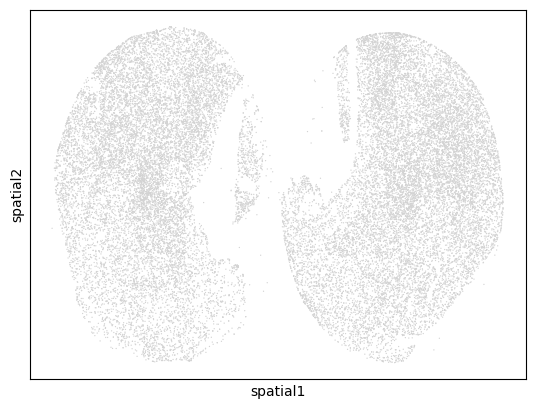

In [11]:
# Remove qc metric columns that are no more correct after using cell itersection
    # pct_intronic --> not totally correct, but lets leave it
adata.obs = adata.obs[["x", "y", "pct_intronic", "is_cell"]]

# Add spatila data
adata.obsm["spatial"] = adata.obs[["x","y"]].values
sc.pl.embedding(adata, basis="spatial")#, color="nCount_RNA")

# Save raw counts
adata.layers["counts"] = adata.X.copy()

# 4. Save

In [12]:
adata.write("/home/gdallagl/myworkdir/XDP/data/XDP/disease/240805_SL-EXD_0328_B22FKKYLT4/SI-TT-H1/adata/raw_adata.h5ad")